<a href="https://colab.research.google.com/github/EvanM19/Projet-scoring/blob/main/discretization/tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data and library importation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown, display
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_text
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [4]:
colonnes_a_supprimer = [ 'id_client', 'CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209','INDPARDCD','CRTOP_AG_IND_0038', 'CRTOP_IND_0038', 'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3', 'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite', 'secteur_activite_bis' ]
samples = samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)
sample['datdelhis'] = sample['datdelhis'] % 100
sample['datdelhis'] = sample['datdelhis'].astype(str)

In [5]:
def discretize_supervised(data, target, features, n, min_fraction=0.3):
    discretized_columns = []
    for feature in features:
        X = data[[feature]].values
        y = data[target].values

        clf = DecisionTreeClassifier(
            max_leaf_nodes=n,
            random_state=42,
            min_samples_split=0.05,
        )
        clf.fit(X, y)

        thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])
        if len(thresholds) == 0:
            continue
        def assign_class(value):
            for i, threshold in enumerate(thresholds):
                if value <= threshold:
                    return i
            return len(thresholds)

        # Apply discretization
        discretized_column = data[feature].apply(assign_class)
        column_name = f"{feature}_discretized"
        data[column_name] = discretized_column
        discretized_columns.append(column_name)
        
        discretized_column = sample[feature].apply(assign_class)
        sample[column_name] = discretized_column
        discretized_column = test[feature].apply(assign_class)
        test[column_name] = discretized_column
        discretized_column = oot[feature].apply(assign_class)
        oot[column_name] = discretized_column

        print(f"Thresholds for '{feature}': {thresholds}")
        print(export_text(clf, feature_names=[feature]))

    return data, discretized_columns


def plot_discretized_classes(data, target, discretized_columns, date_col):
    for column in discretized_columns:
        grouped = (
            data.groupby([date_col, column])[target]
            .mean()
            .reset_index()
            .rename(columns={target: 'Default_Rate'})
        )
        pivot_table = grouped.pivot(index=date_col, columns=column, values='Default_Rate')

    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    plt.plot(pivot_table, marker='o', linestyle='-') 
    plt.title(f"Discretization Results for {column}")
    plt.xlabel("Date")
    plt.ylabel("Default Rate")
    plt.grid()
    plt.tight_layout()


def f(x, y):
    # Apply discretization
    train_discretized, discretized_cols = discretize_supervised(
        train, 'DDefaut_NDB', [x], n=y, min_fraction=0.05
    )
    
    # Plot discretized classes
    plot_discretized_classes(train_discretized, 'DDefaut_NDB', discretized_cols, date_col='datdelhis')
    
    discretized_col_name = f"{x}_discretized"
    try:
        # Calculate the average defect rate over time
        taux_defaut_temps = sample.groupby([discretized_col_name, "datdelhis"])["DDefaut_NDB"].mean().reset_index()
    except KeyError:
        print(f"Error: The column '{discretized_col_name}' does not exist in the sample.")
        return
    
    # Plot defect rate over time
    plt.subplot(1,2,2)
    sns.lineplot(x="datdelhis", y="DDefaut_NDB", hue=discretized_col_name, data=taux_defaut_temps, ci=None, marker='o')
    plt.title("Stability of Discretized Modalities Over Time (Train, Test, OOT)")
    plt.xlabel("Time (datdelhis)")
    plt.ylabel("Default Rate")
    plt.grid(True)
    plt.legend(title="Modality")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    try:
        # Analyze the distribution of categories by effect count
        modalites_count = sample[discretized_col_name].value_counts(normalize=True) * 100
    except KeyError:
        print(f"Error: The column '{discretized_col_name}' does not exist in the sample.")
        return

    # Plot the distribution of effect counts
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    modalites_count.plot(kind="bar", color="skyblue")
    plt.title("Distribution of Effect Counts by Modality")
    plt.xlabel("Modality")
    plt.ylabel("Effect Count (%)")
    plt.grid(True)
    plt.tight_layout()

    # Filter the effect count by a minimum threshold of 5%
    min_effectif = 5  
    modalites_filtres = modalites_count[modalites_count >= min_effectif]

    # Calculate the average defect rate across groups
    taux_criteres = sample.groupby([discretized_col_name])["DDefaut_NDB"].mean().reset_index()
    max_diff = taux_criteres['DDefaut_NDB'].max() - taux_criteres['DDefaut_NDB'].min()

    # Assess if the separation between groups meets the required threshold
    separation_requise = 0.30  
    separation = max_diff / taux_criteres['DDefaut_NDB'].max()

    # Plot the percentage of defect differences across modalities
    plt.subplot(1,2,2)
    sns.barplot(x=discretized_col_name, y="DDefaut_NDB", data=taux_criteres, color="lightcoral")
    plt.title("Percentage Relative Deviation Between Modalities")
    plt.xlabel("Modality")
    plt.ylabel("Default Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if len(modalites_filtres) == len(modalites_count):
        print(f"All modalities have effect counts greater than or equal to {min_effectif}%.")
    else:
        print(f"/!\\ Some modalities have effect counts less than {min_effectif}%.")

    print(" ")

    if separation >= separation_requise:
        print(f"Criterion 4: Modalities are separated by at least {separation_requise * 100}% in terms of default rate.")
    else:
        print(f"Criterion 4: Modalities are not separated by at least {separation_requise * 100}% in terms of default rate.")
    print(" ")
    print(" ")
    print(" ")


Thresholds for 'CRTOC_IND_0015': [ 3.5 27.5]
|--- CRTOC_IND_0015 <= 27.50
|   |--- CRTOC_IND_0015 <= 3.50
|   |   |--- class: 0
|   |--- CRTOC_IND_0015 >  3.50
|   |   |--- class: 0
|--- CRTOC_IND_0015 >  27.50
|   |--- class: 0



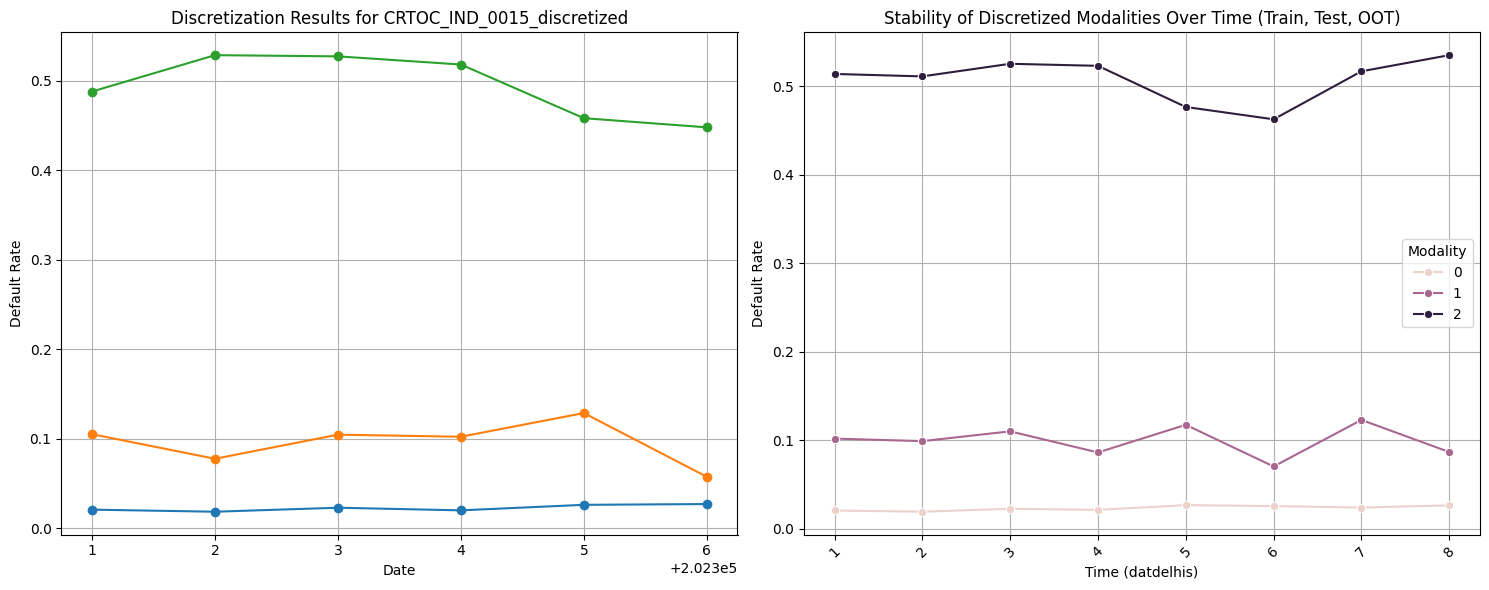

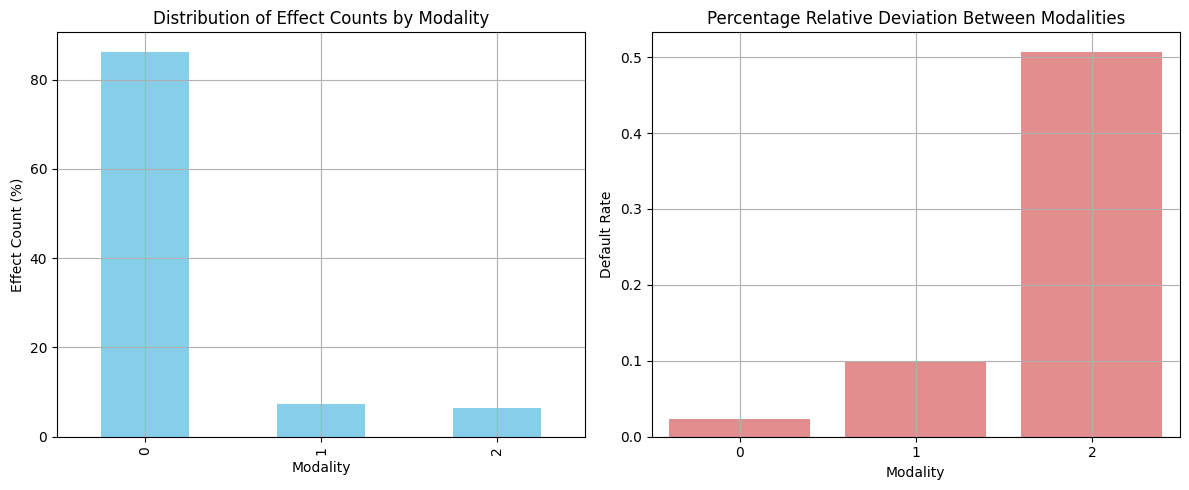

All modalities have effect counts greater than or equal to 5%.
 
Criterion 4: Modalities are separated by at least 30.0% in terms of default rate.
 
 
 
Thresholds for 'CRTOC_AG_LIGDEB_2T_IND_0015': [-1422266.   -403533.5]
|--- CRTOC_AG_LIGDEB_2T_IND_0015 <= -403533.50
|   |--- CRTOC_AG_LIGDEB_2T_IND_0015 <= -1422266.00
|   |   |--- class: 0
|   |--- CRTOC_AG_LIGDEB_2T_IND_0015 >  -1422266.00
|   |   |--- class: 0
|--- CRTOC_AG_LIGDEB_2T_IND_0015 >  -403533.50
|   |--- class: 0



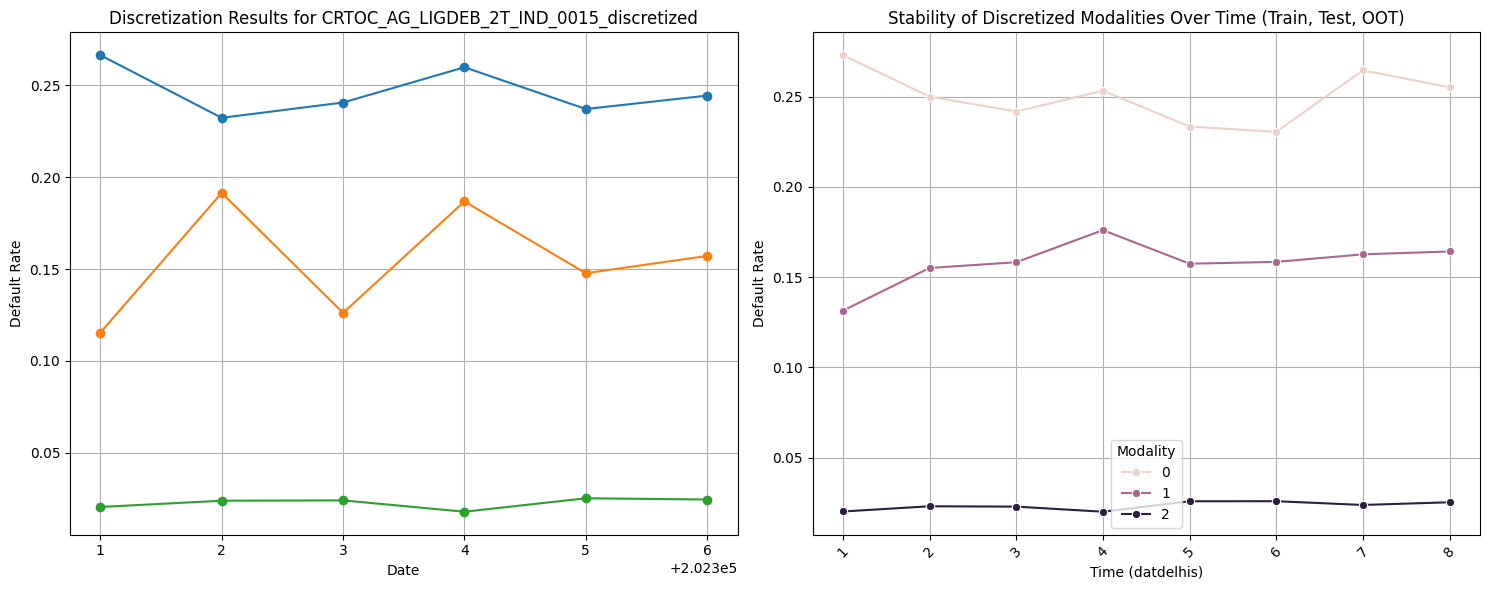

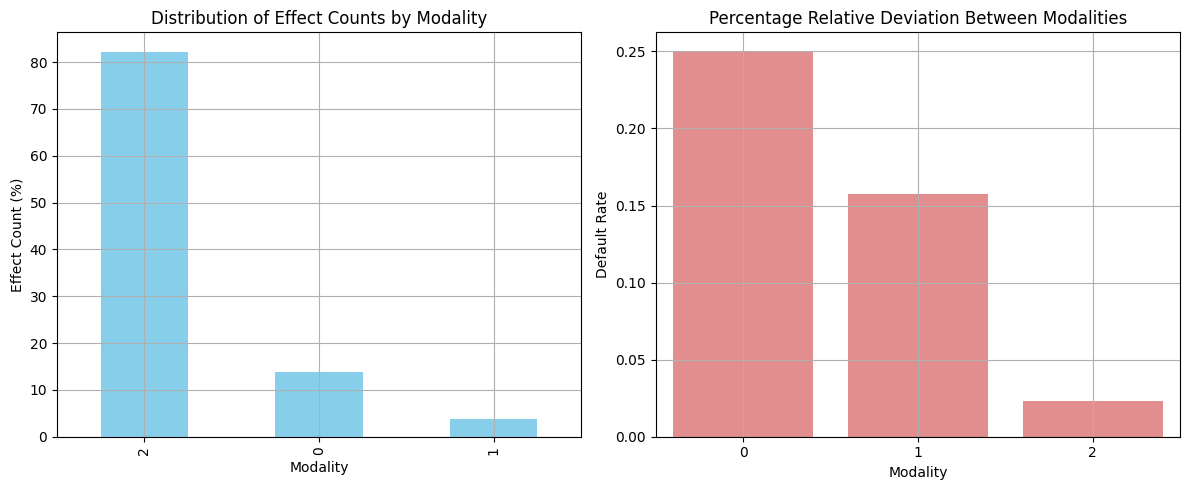

/!\ Some modalities have effect counts less than 5%.
 
Criterion 4: Modalities are separated by at least 30.0% in terms of default rate.
 
 
 
Thresholds for 'CRTOC_IND_0164': [-192950.   -3950.]
|--- CRTOC_IND_0164 <= -3950.00
|   |--- CRTOC_IND_0164 <= -192950.00
|   |   |--- class: 0
|   |--- CRTOC_IND_0164 >  -192950.00
|   |   |--- class: 1
|--- CRTOC_IND_0164 >  -3950.00
|   |--- class: 0



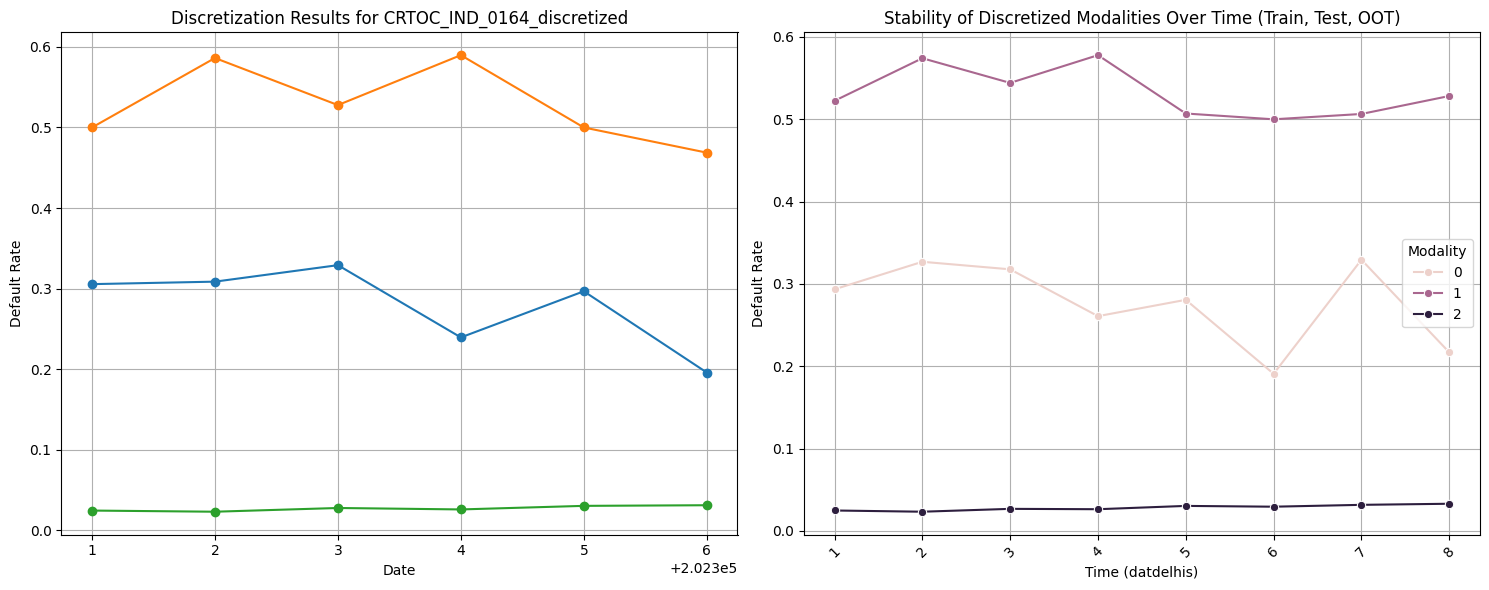

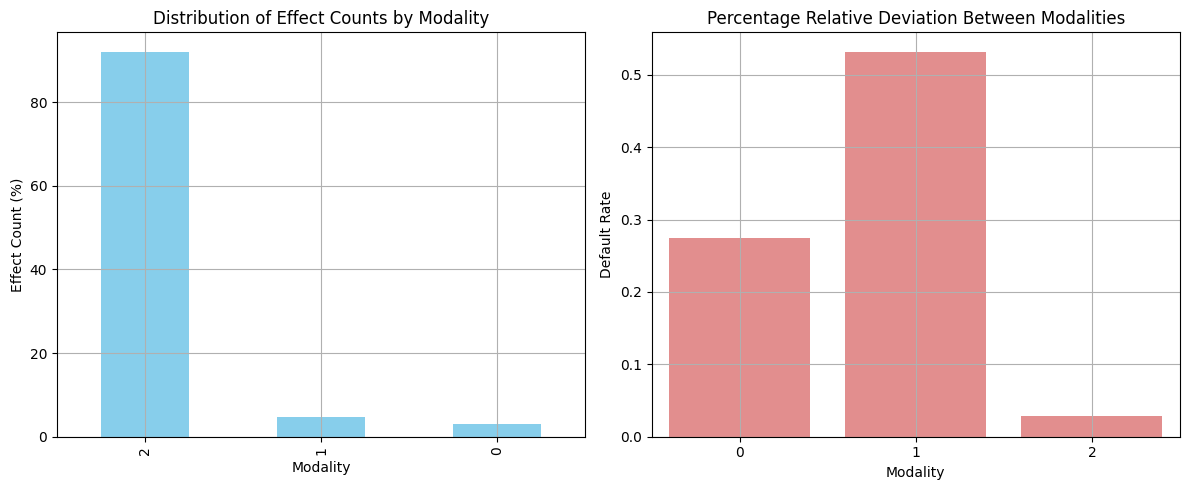

/!\ Some modalities have effect counts less than 5%.
 
Criterion 4: Modalities are separated by at least 30.0% in terms of default rate.
 
 
 
Thresholds for 'CRTOC_AG_NBJCRE_2T_IND_0009': [ 11.5 134.5 180.5]
|--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 11.50
|   |--- class: 0
|--- CRTOC_AG_NBJCRE_2T_IND_0009 >  11.50
|   |--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 134.50
|   |   |--- class: 0
|   |--- CRTOC_AG_NBJCRE_2T_IND_0009 >  134.50
|   |   |--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 180.50
|   |   |   |--- class: 0
|   |   |--- CRTOC_AG_NBJCRE_2T_IND_0009 >  180.50
|   |   |   |--- class: 0



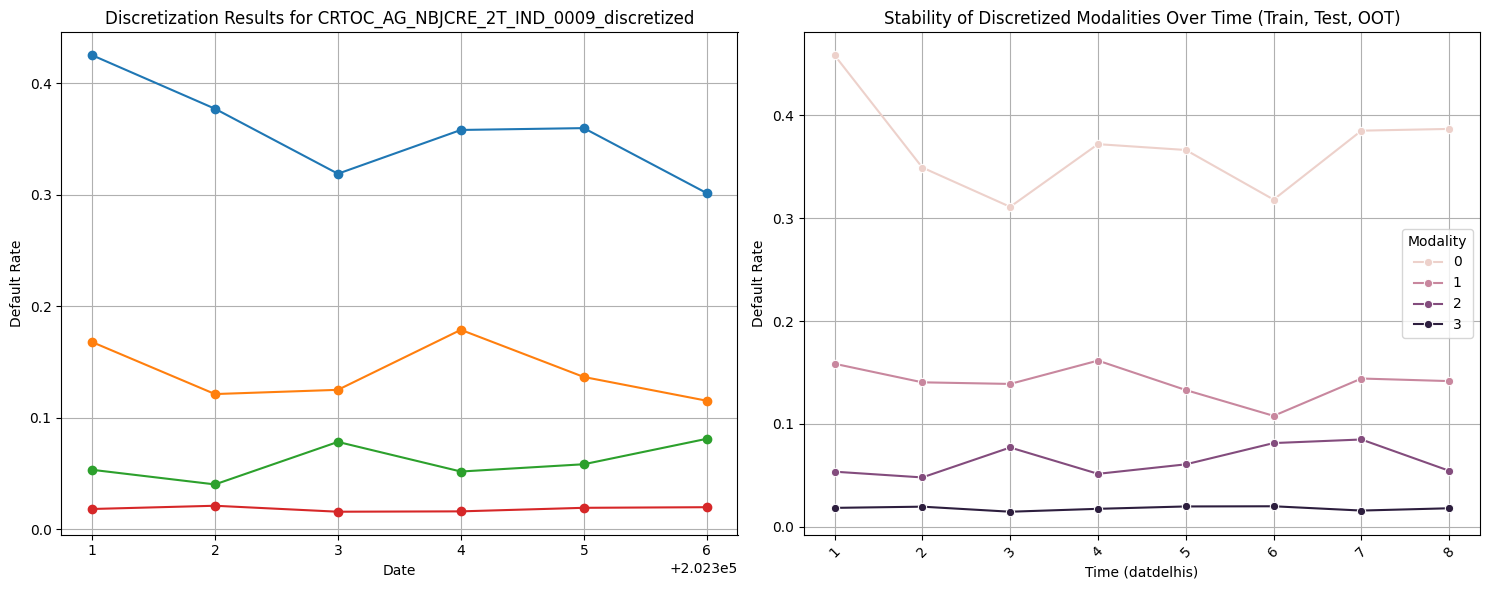

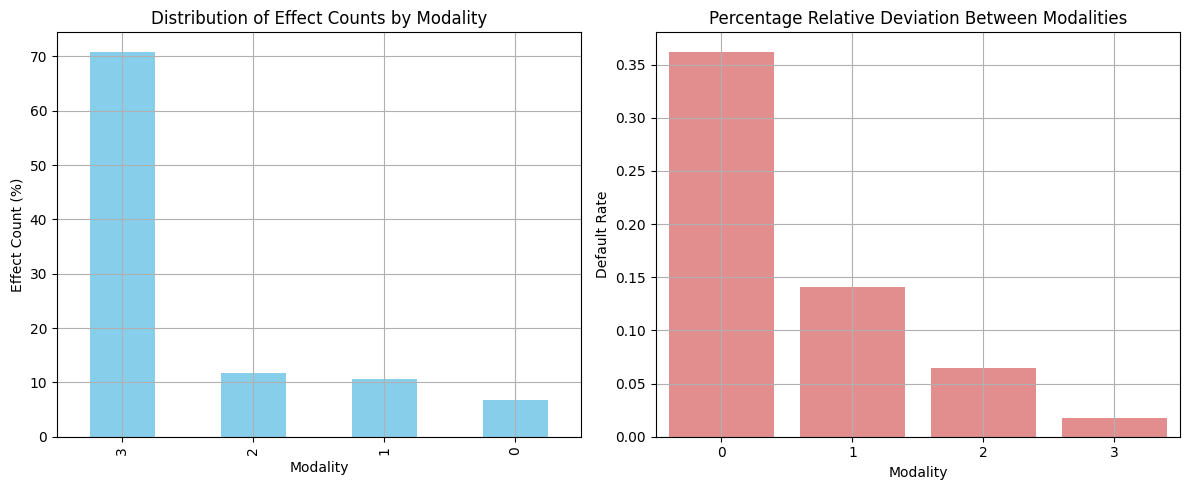

All modalities have effect counts greater than or equal to 5%.
 
Criterion 4: Modalities are separated by at least 30.0% in terms of default rate.
 
 
 
Thresholds for 'CRTOC_AG_MVTAFF_2T_IND_0010': [  14156. 1811925.]
|--- CRTOC_AG_MVTAFF_2T_IND_0010 <= 14156.00
|   |--- class: 0
|--- CRTOC_AG_MVTAFF_2T_IND_0010 >  14156.00
|   |--- CRTOC_AG_MVTAFF_2T_IND_0010 <= 1811925.00
|   |   |--- class: 0
|   |--- CRTOC_AG_MVTAFF_2T_IND_0010 >  1811925.00
|   |   |--- class: 0



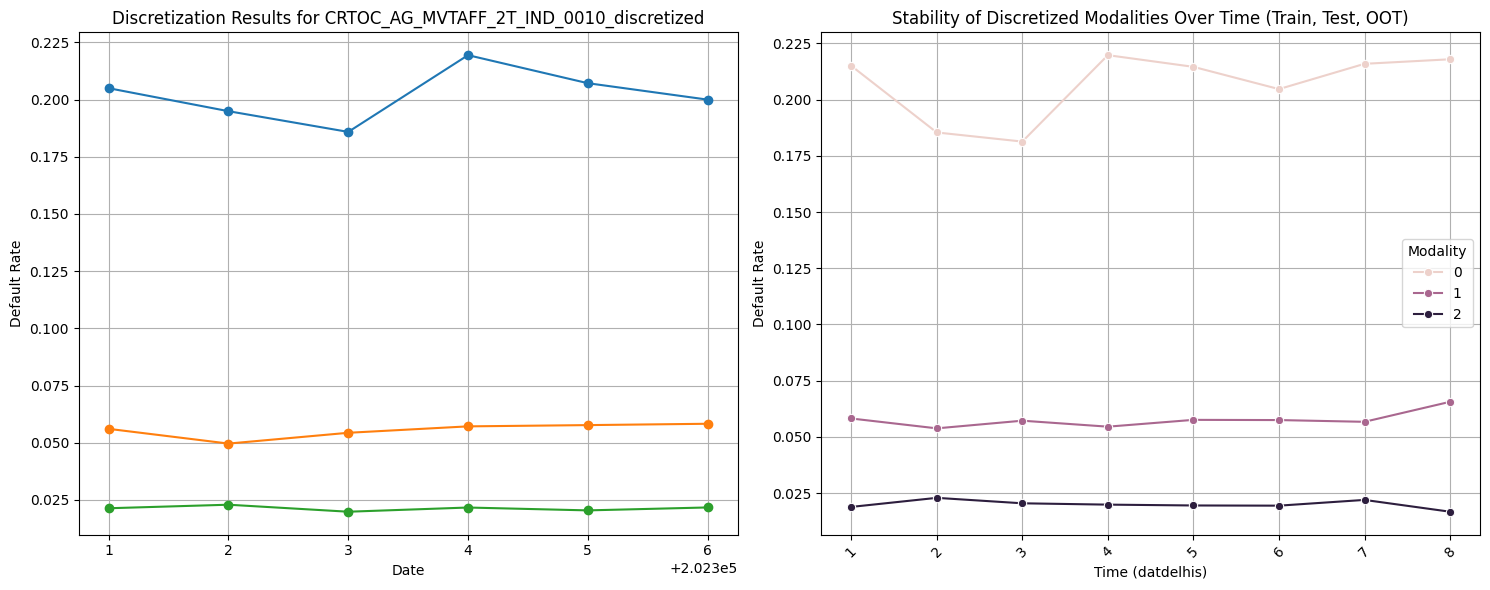

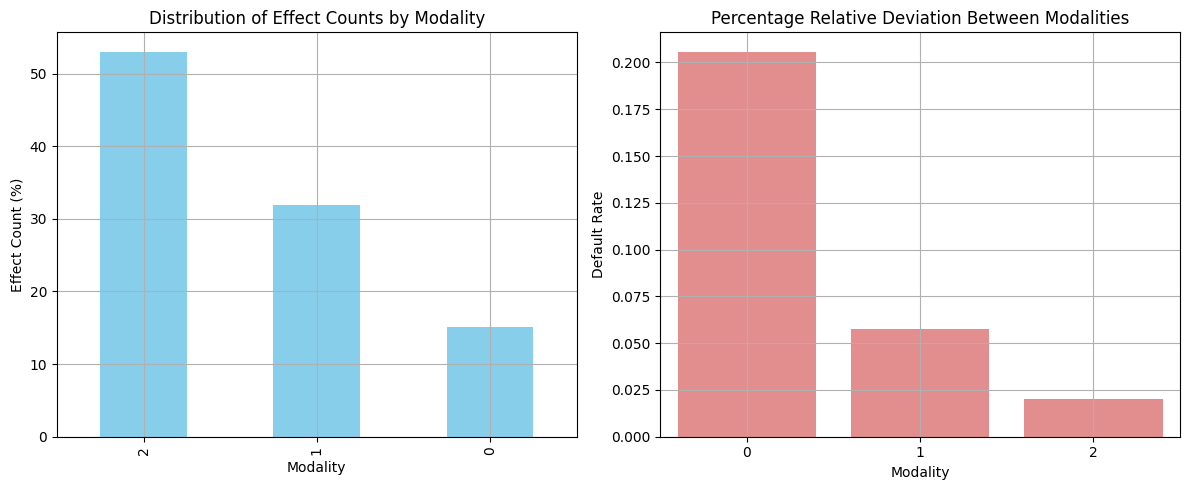

All modalities have effect counts greater than or equal to 5%.
 
Criterion 4: Modalities are separated by at least 30.0% in terms of default rate.
 
 
 


In [6]:
quantitative_cols_after_wallis_pearson = ['CRTOC_IND_0015',3, 'CRTOC_AG_LIGDEB_2T_IND_0015',3, 'CRTOC_IND_0164',3,
    'CRTOC_AG_NBJCRE_2T_IND_0009',4, 'CRTOC_AG_MVTAFF_2T_IND_0010',3]
y=[quantitative_cols_after_wallis_pearson[(i*2)-1] for i in range(1, int(len(quantitative_cols_after_wallis_pearson)/2) + 1)]
x=[quantitative_cols_after_wallis_pearson[i*2] for i in range(int(len(quantitative_cols_after_wallis_pearson)/2))]

for i in range(len(x)):
  f(x[i],y[i])